# **Customer Clustering**
- The objective of this task is to cluster customers of a shopping mall to understand customers better in order to retain said customers.

Questions to be answered:

- How to perform customer segmentation using unsupervised machine learning algorithm in Python?
- Describe the characteristics of each customer cluster.
- Which group of customer is the most valuable to the shopping mall so that the shopping mall should do something to retain them?

In [115]:
from typing import Sequence, Tuple
from itertools import combinations, chain
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import sklearn
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering
from scipy.cluster.hierarchy import dendrogram
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering, MeanShift, estimate_bandwidth
from sklearn.metrics import silhouette_score, silhouette_samples, calinski_harabasz_score

df = pd.read_csv("Customer_Dataset.csv")

## **Data Exploration**

In [116]:
df.head()

,CustomerID,Gender,Age,Income (k$),How Much They Spend
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [117]:
rows, cols = df.shape
print("There are {} rows and {} features in the data.".format(rows, cols))

There are 200 rows and 5 features in the data.


In [118]:
df.describe(include='all')

,CustomerID,Gender,Age,Income (k$),How Much They Spend
count,200.000000,200,200.000000,200.000000,200.000000
unique,NaN,2,NaN,NaN,NaN
top,NaN,Female,NaN,NaN,NaN
freq,NaN,112,NaN,NaN,NaN
mean,100.500000,NaN,38.850000,60.560000,50.200000
std,57.879185,NaN,13.969007,26.264721,25.823522
min,1.000000,NaN,18.000000,15.000000,1.000000
25%,50.750000,NaN,28.750000,41.500000,34.750000
50%,100.500000,NaN,36.000000,61.500000,50.000000
75%,150.250000,NaN,49.000000,78.000000,73.000000


From the `.head` function, we find that:

|Columns|	Descriptions|
| :---: | :---: |
|CustomerId| Unique identifier for each customer |
|Gender| Gender of each customer |
|Age| Age of customers |
|Annual Income (k$)| Annual Income of the customer in thousands|
|Spending Score (1-100)| Score assigned by the mall based on customer behavior and spending nature |

In total, there are 4 numerical columns, `CustomerID` , `Age` , `Income (k$)` and `How Much They Spend` and only 1 categorical column, `Gender`

## **Exploratory Data Analysis**

Firstly, I would like to edit some of the feature names so that they are easier to use and less confusing for me.

In this section, I would like to:
- Perform univariate/bivariate analysis
- Check the distribution of numerical data
- Check the count of categorical data
- Identify columns that require scaling
- Find any correlations between features/ Any clusters formed

In [119]:
new_names = { 
    'CustomerID': 'cust_id',
    'Gender': 'gender',
    'Age': 'age', 
    'Income (k$)': 'salary(k$)',
    'How Much They Spend': 'amt_spent',
}
df.rename(columns = new_names, inplace=True)
df.head()

,cust_id,gender,age,salary(k$),amt_spent
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


#### **Univariate Analysis**

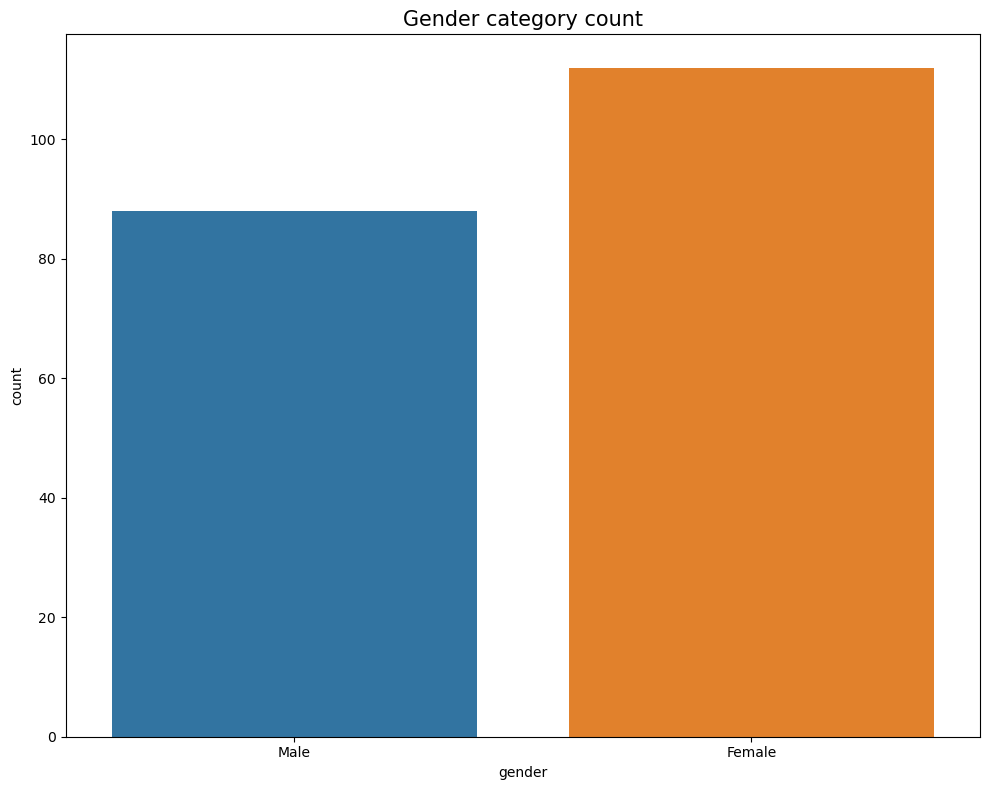

In [120]:
# Categorical count

fig = plt.figure(tight_layout = True, figsize = (10, 8))
ax = sns.countplot(x = df['gender'], data = df)
ax.set_title(f'Gender category count', fontsize=15)

plt.show()

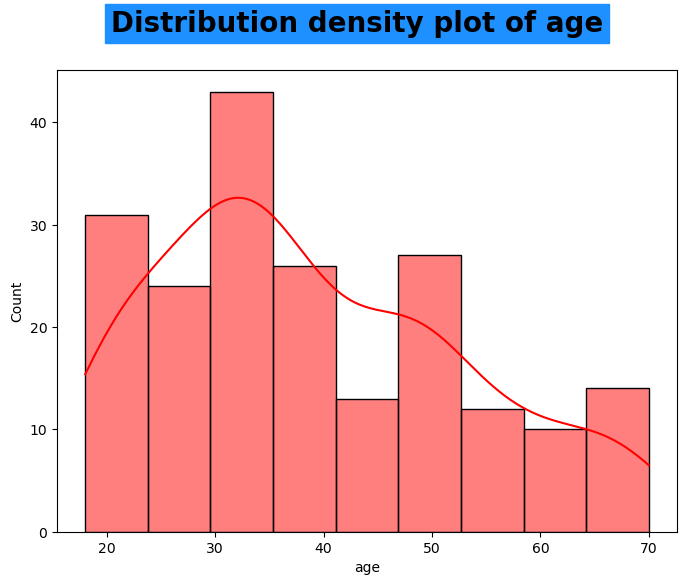

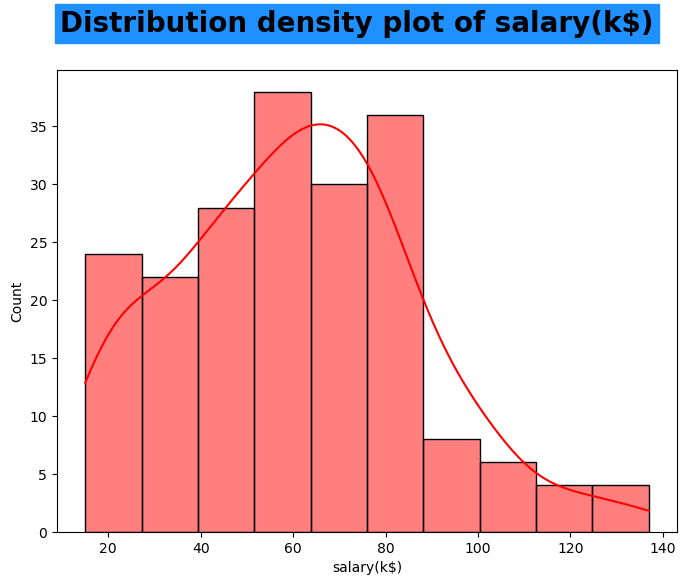

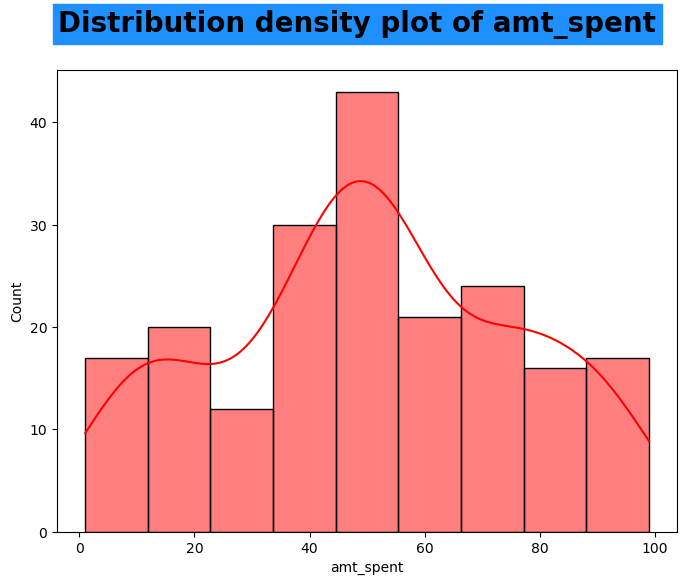

In [121]:
#Data Distribution
quant_features = ['age', 'salary(k$)', 'amt_spent']

for feature in quant_features:
  fig = plt.figure(figsize=(8,6))
  sns.histplot(data=df, x = feature, kde=True, color='red', alpha=0.5)

  fig.suptitle(f'Distribution density plot of {feature}',color='black',weight='bold',size=20, backgroundcolor= 'Dodgerblue')

  plt.show()

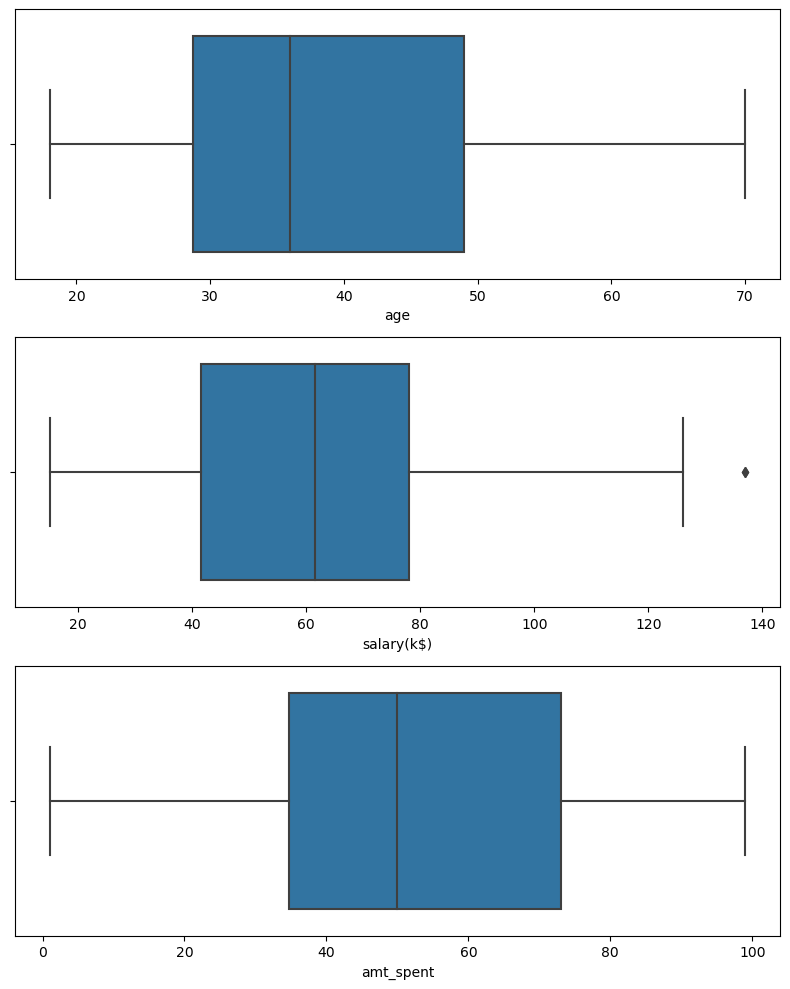

In [122]:
fig, ax = plt.subplots(len(quant_features), 1, figsize=(8, 10), tight_layout=True)
for idx, feature in enumerate(quant_features):
    sns.boxplot(data = df, x=feature, ax = ax[idx])
fig.show()

As we can see from the univariate analysis, all of the variables require normalising. `salary` and `age` is positively skewed while amt_spent actually has a quite similar distribution to gaussian distribution. I feel that there is no need to scale due to the fact that the range of each data is quite similar. 

From the boxplot, we can see that:

- The average:
    - Age is about 36
    - Salary is about $62000 a year
    - amt_spent (from a range of 0-100) is 45
- There is only one outlier in all 3 features, which is salary.

#### **Pairplot**

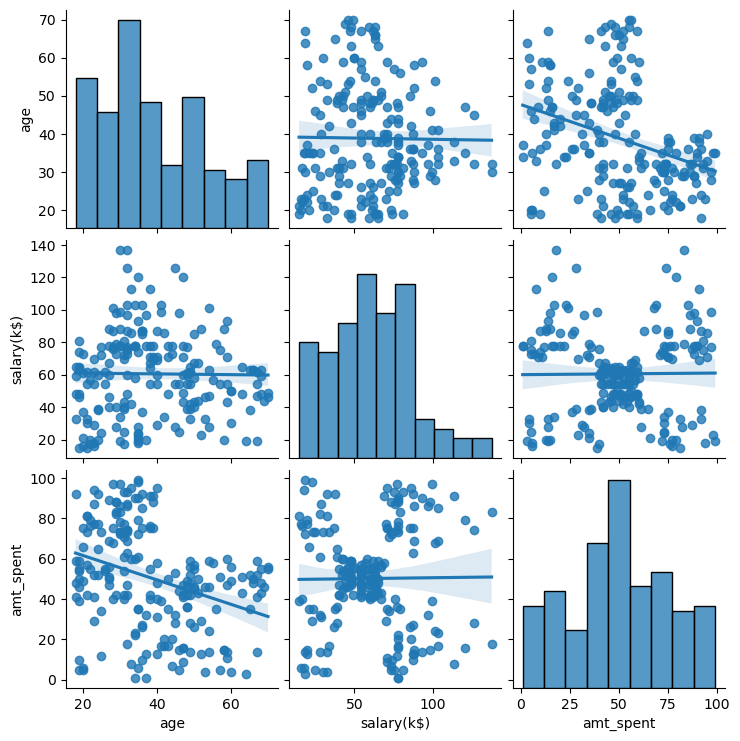

In [123]:
#Drop gender and cust id from df
df_num = df.drop(columns=['gender', 'cust_id'], axis=1)
sns.pairplot(df_num, kind='reg')

As we can see from the pairplot: 
- There are 5 natural clusters that appear between the amount spent and salary earnt
- We can also see that as the customers age increasing, the amount of money spent decreases.
- Apart from Age and Amount spent, there are no other significant relationships.
However to validify the last point, I will also plot a correlation plot.

In the next correlation plot, I will be using phi k as the correlation coefficient. It is better at identifying non linear relationships that may be available between different features. This identifies dependencies between each pair of variables better. This photo represents it:


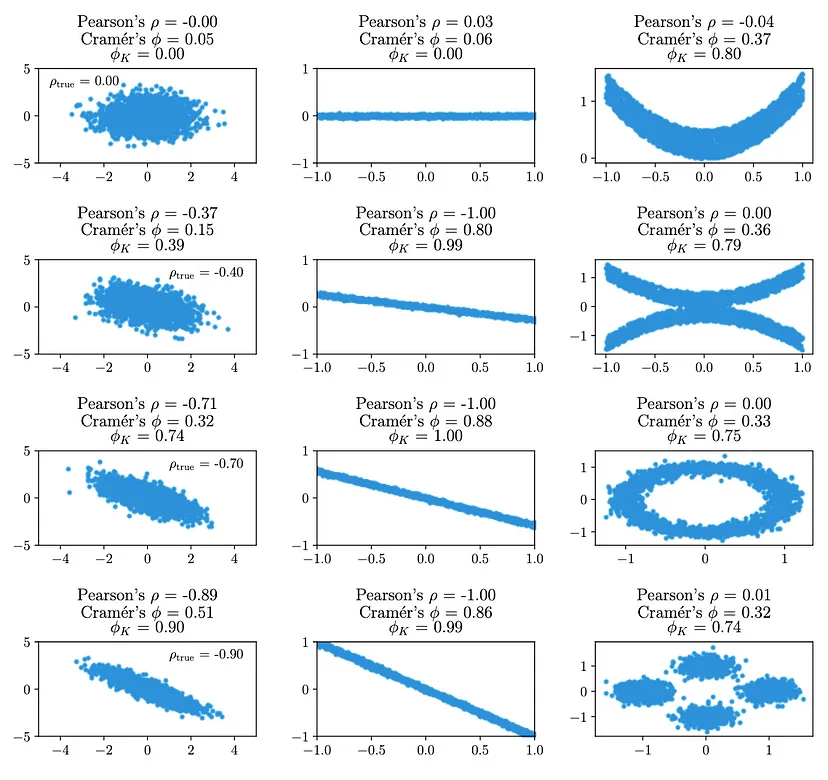

interval columns not set, guessing: ['age', 'salary(k$)', 'amt_spent']


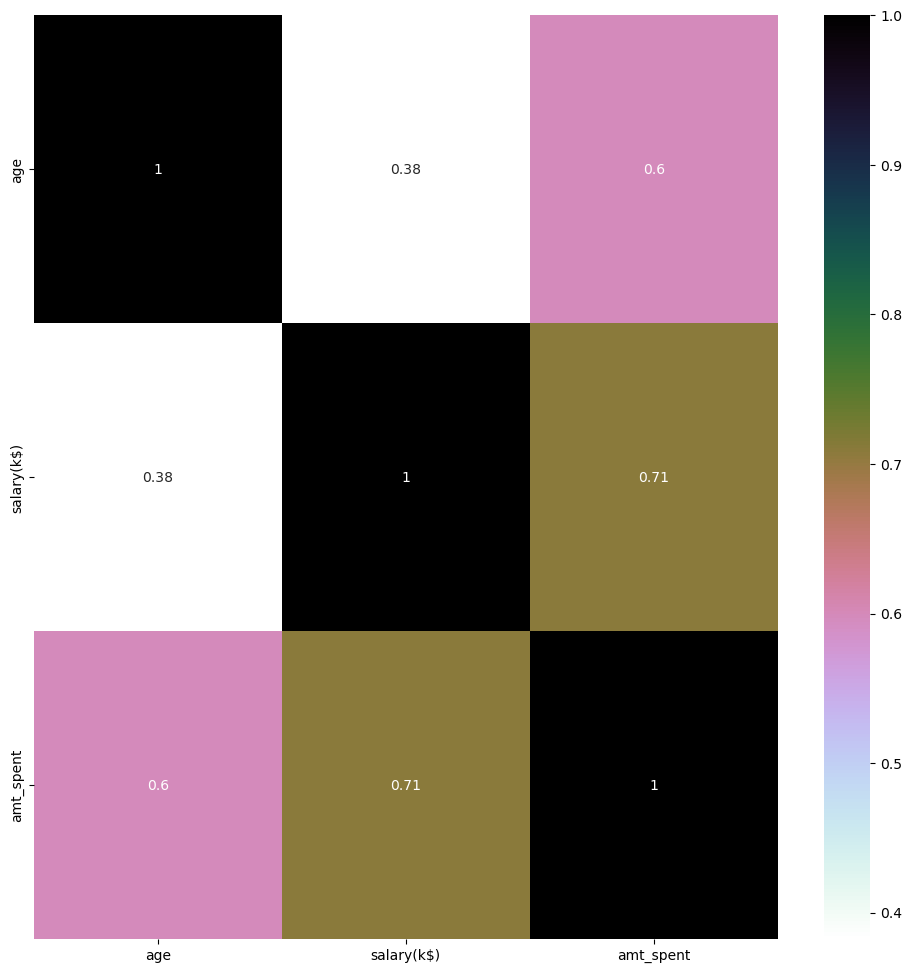

In [124]:
import phik
from phik.report import plot_correlation_matrix
from phik import report
from phik import resources, report

plt.figure(figsize=(12,12))
sns.heatmap(
    df_num.phik_matrix(),
    cmap="cubehelix_r",
    annot = True)
plt.show()

As we can see from the $\varphi_k$ correlation coefficient, `salary`/`amt_spent` and `age`/`amt_spent` have a moderate positive correlation. This could be because:
- People who earn more money would be able to spend more as they have more leeway for cash as a result of their salary. Hence they would naturally spend more as compared to someone who earns lesser money.
- Older people may need more, especially groups such as parents, as compared to students. This may be the reason why older customers tend to spend more money.


 On the other hand, `salary` and `age` have a weak correlation coefficient. 

## **Data Preprocessing**

There are a few steps that need to be performed before I can start clustering to ensure that the data is in a suitable format for analysis and modeling and handle any inherent issues or limitations in the data.
 1. As customer id is a unique identifier given to all customers and does not review any useful information, I will drop the column. 
 2. Next, as seen earlier, we will need to normalise the data as some are positively skewed.
 3. I need to create a dichotomous variable for `Gender`.
 4. I would also like to do feature selection and see if ALL of the features are needed, or whether, there is an optimal number/some features that I can drop.


In [125]:
#Drop cust_id
clean_df = df.drop(columns=['cust_id'], axis=1)

In [126]:
#Encoding gender column where gender_Male = 1 means that the customer is male
clean_df = pd.get_dummies(clean_df, drop_first=True)

In [127]:
clean_df

,age,salary(k$),amt_spent,gender_Male
0,19,15,39,1
1,21,15,81,1
2,20,16,6,0
3,23,16,77,0
4,31,17,40,0
...,...,...,...,...
195,35,120,79,0
196,45,126,28,0
197,32,126,74,1
198,32,137,18,1


In [128]:
#Normalise data
'''
In this case, I'll be using Quantile Transformer. This is because it transforms the data to follow a uniform or Gaussian distribution and is useful for handling skewed data.
This is perfect for the features in this dataset as they are all positvely skewed with very little outliers. 
'''
from sklearn.preprocessing import QuantileTransformer
def apply_quantile_transform(df, numcols, n_quantiles=100, random_state=None):
    qt = QuantileTransformer(n_quantiles=n_quantiles, random_state=random_state)

    df[numcols] = qt.fit_transform(df[numcols])
    
    return df

df_transformed = apply_quantile_transform(clean_df, quant_features ,n_quantiles=100, random_state=42)

In [129]:
display(df_transformed)

,age,salary(k$),amt_spent,gender_Male
0,0.035354,0.000000,0.291719,1
1,0.095960,0.000000,0.858586,1
2,0.065657,0.010101,0.050000,0
3,0.136364,0.010101,0.828283,0
4,0.328283,0.020202,0.303030,0
...,...,...,...,...
195,0.469697,0.979798,0.848485,0
196,0.666667,0.989899,0.212121,0
197,0.373737,0.989899,0.780000,1
198,0.373737,1.000000,0.164600,1


#### **Feature Selection**

For feature selection, I decided to use a Genetic Algorithm. I think these 2 photos are enough to describe the process of using a genetic algorithm to select features.<br>
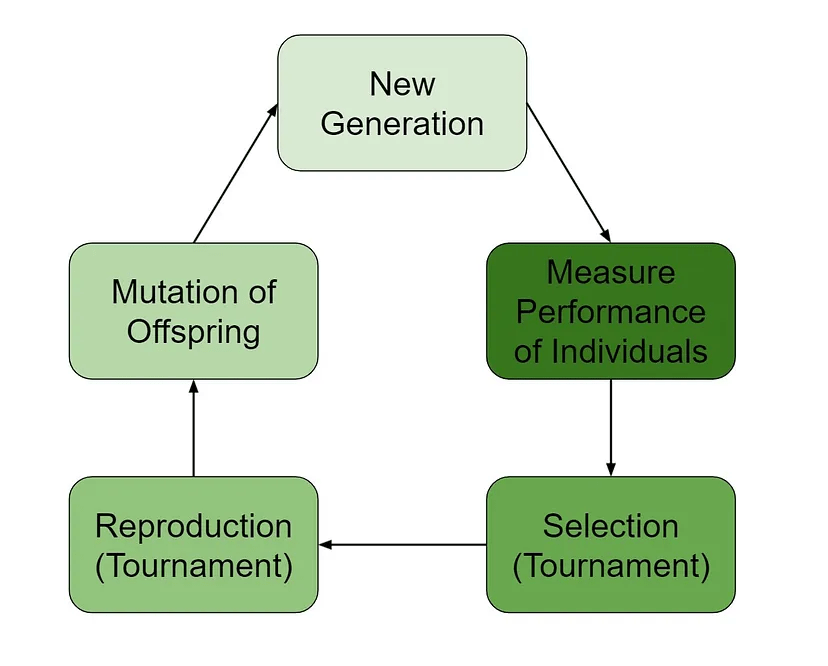<br>

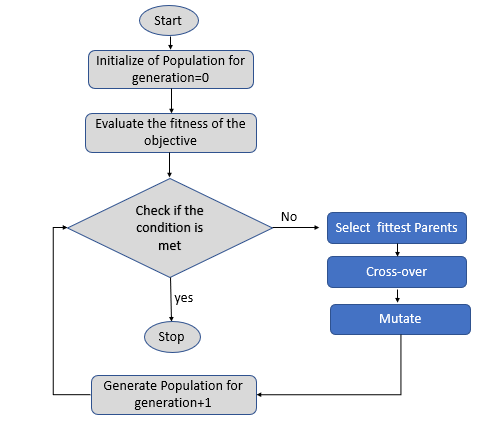

In [130]:
# import numpy as np
# from sklearn.cluster import KMeans
# from sklearn.metrics import silhouette_score
# import pandas as pd
# '''
# 1. Used a function to determine the silhouette score of the data
# 2. Created an initial population with undefined chromosomes
# 3. Create a function to select parents from the population
# 4. Create a function to perform crossover
# 5. Mutate data
# 6. Termination criteria
# 7. Run the genetic algorithm
# '''

# def fitness_function(feature_subset, X):
#     kmeans = KMeans(n_clusters=2, random_state=0)
#     cluster_labels = kmeans.fit_predict(X[:, feature_subset])
    
#     return silhouette_score(X[:, feature_subset], cluster_labels)

# def create_initial_population(population_size, num_features):
#     initial_population = np.random.randint(2, size=(population_size, num_features))
#     return initial_population

# def select_parents(population, fitness_scores):
#     selected_parents = []
#     num_parents = len(population) // 2
    
#     for _ in range(num_parents):
#         parent_indices = np.random.choice(len(population), size=2, replace=False)
#         parent1_idx, parent2_idx = parent_indices
#         parent1_fitness, parent2_fitness = fitness_scores[parent1_idx], fitness_scores[parent2_idx]
        
#         selected_parent_idx = parent1_idx if parent1_fitness >= parent2_fitness else parent2_idx
#         selected_parents.append(population[selected_parent_idx])
    
#     return np.array(selected_parents)

# def crossover(parents):
#     num_parents, num_features = parents.shape
#     offspring = np.zeros((num_parents, num_features))
    
#     for i in range(num_parents):
#         crossover_point = np.random.randint(1, num_features)
#         offspring[i, :crossover_point] = parents[i, :crossover_point]
#         offspring[i, crossover_point:] = parents[i - 1, crossover_point:]
    
#     return offspring

# def mutate(offspring, mutation_rate):
#     num_offspring, num_features = offspring.shape
    
#     for i in range(num_offspring):
#         for j in range(num_features):
#             if np.random.rand() < mutation_rate:
#                 offspring[i, j] = 1 - offspring[i, j]
    
#     return offspring

# def termination_criteria(generation, max_generations, target_fitness):
#     return generation >= max_generations

# def genetic_algorithm(X, population_size, max_generations, mutation_rate, target_fitness):
#     num_features = X.shape[1]
#     population = create_initial_population(population_size, num_features)
    
#     for generation in range(max_generations):
#         fitness_scores = [fitness_function(feature_subset, X) for feature_subset in population]
#         best_fitness = max(fitness_scores)
#         best_feature_subset = population[np.argmax(fitness_scores)]
        
#         if termination_criteria(generation, max_generations, target_fitness):
#             break
        
#         selected_parents = select_parents(population, fitness_scores)
#         offspring = crossover(selected_parents)
#         mutated_offspring = mutate(offspring, mutation_rate)
#         population = mutated_offspring
    
#     return best_feature_subset

# if __name__ == "__main__":
#     np.random.seed(42)  # For reproducibility
    
#     # Generate a synthetic dataset for demonstration purposes
#     n_samples, n_features = 100, 10
#     X = np.random.rand(n_samples, n_features)

#     population_size = 50
#     max_generations = 20
#     mutation_rate = 0.1
#     target_fitness = 0.8
    
#     selected_feature_subset = genetic_algorithm(X, population_size, max_generations, mutation_rate, target_fitness)
    
#     # Get the indices of selected features
#     selected_feature_indices = np.where(selected_feature_subset == 1)[0]
    
#     # Print the selected features
#     print("Selected Feature Indices:", selected_feature_indices)


In [131]:
print(clean_df[['age', 'salary(k$)', 'amt_spent']].values)

[[0.03535354 0.         0.29171884]
 [0.0959596  0.         0.85858586]
 [0.06565657 0.01010101 0.05      ]
 [0.13636364 0.01010101 0.82828283]
 [0.32828283 0.02020202 0.3030303 ]
 [0.11111111 0.02020202 0.81818182]
 [0.46969697 0.03030303 0.05      ]
 [0.13636364 0.03030303 0.96999406]
 [0.92995998 0.04545455 0.01005025]
 [0.29292929 0.04545455 0.74      ]
 [0.96464646 0.04545455 0.11111111]
 [0.46969697 0.04545455 1.        ]
 [0.87878788 0.06565657 0.13131313]
 [0.16161616 0.06565657 0.82828283]
 [0.52525253 0.06565657 0.09090909]
 [0.11111111 0.06565657 0.84848485]
 [0.46969697 0.08080808 0.25757576]
 [0.06565657 0.08080808 0.71237458]
 [0.81818182 0.09090909 0.22222222]
 [0.46969697 0.09090909 0.99494949]
 [0.46969697 0.1010101  0.25757576]
 [0.18181818 0.1010101  0.76262626]
 [0.67676768 0.11111111 0.03030303]
 [0.32828283 0.11111111 0.76262626]
 [0.84343434 0.12626263 0.11111111]
 [0.25757576 0.12626263 0.86399126]
 [0.66666667 0.12626263 0.23851417]
 [0.46969697 0.12626263 0.69

at the end, see if gender really makes a diff? like try to plot and see if theres a point keeping that column

<hr>

## **Sources**

https://www.kaggle.com/code/tanmayunhale/genetic-algorithm-for-feature-selection <br>